## Train and evaluate a LogisticRegression on a dataset that is stored in separate training and testing folders.(set02 test01 known vehicle, known attack)

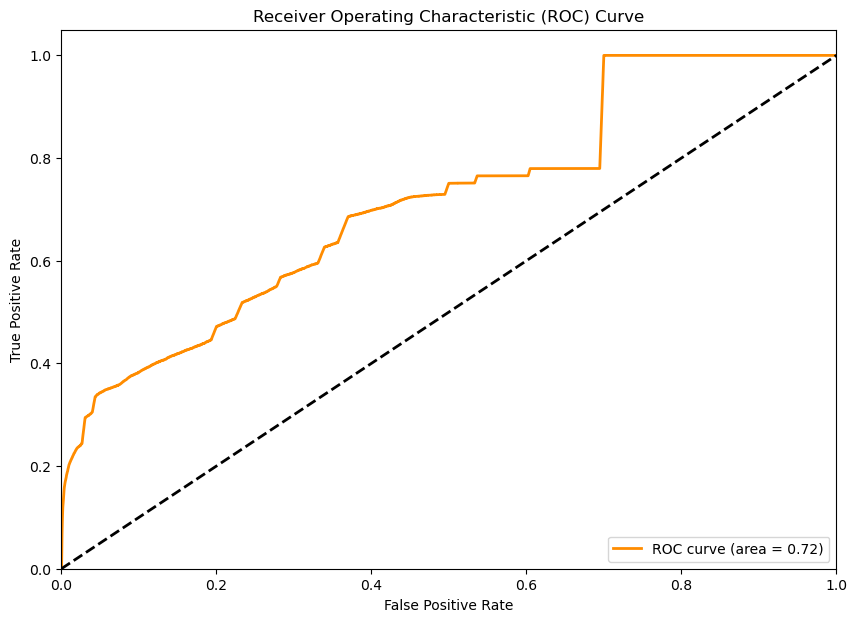

AUC: 0.7153
Accuracy: 0.7527
Precision: 0.9982
Recall: 0.7527
F1-score: 0.8579
Training Time: 23.0250 seconds
Testing Time: 1.6822 seconds

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.75      0.86  13206311
           1       0.00      0.53      0.00     14244

    accuracy                           0.75  13220555
   macro avg       0.50      0.64      0.43  13220555
weighted avg       1.00      0.75      0.86  13220555



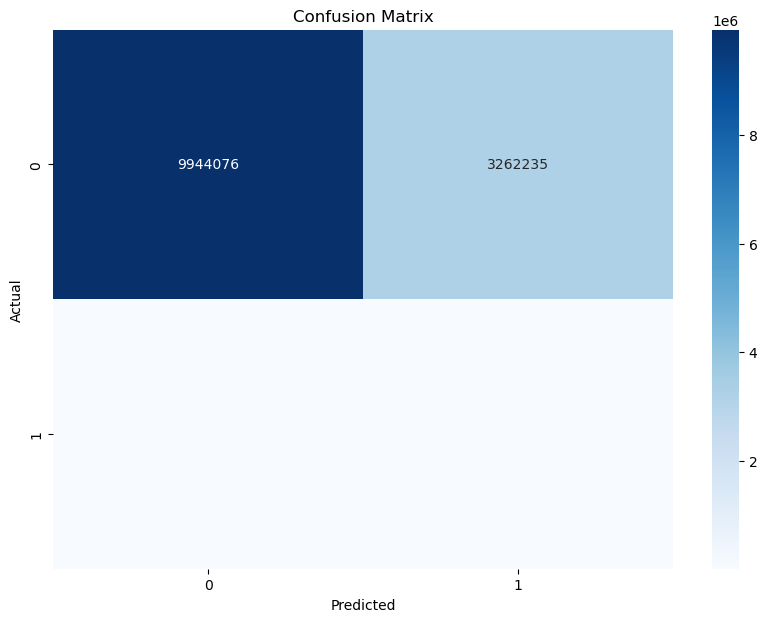

In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_01_known_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Logistic Regression with class weight adjustment
clf = LogisticRegression(random_state=42, class_weight='balanced')

# Measure training time
start_train_time = time.time()
clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = clf.predict(X_test_scaled)
y_pred_prob = clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
classification_rep = classification_report(y_test, y_pred, zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Calculate ROC and AUC
n_classes = len(np.unique(y_train))

if n_classes == 2:
    # Binary classification case
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for binary classification
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class case
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))
print("\nClassification Report:\n", classification_rep)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Train and evaluate a LogisticRegression on a dataset that is stored in separate training and testing folders.(set02 test02 unknown vehicle, known attack)

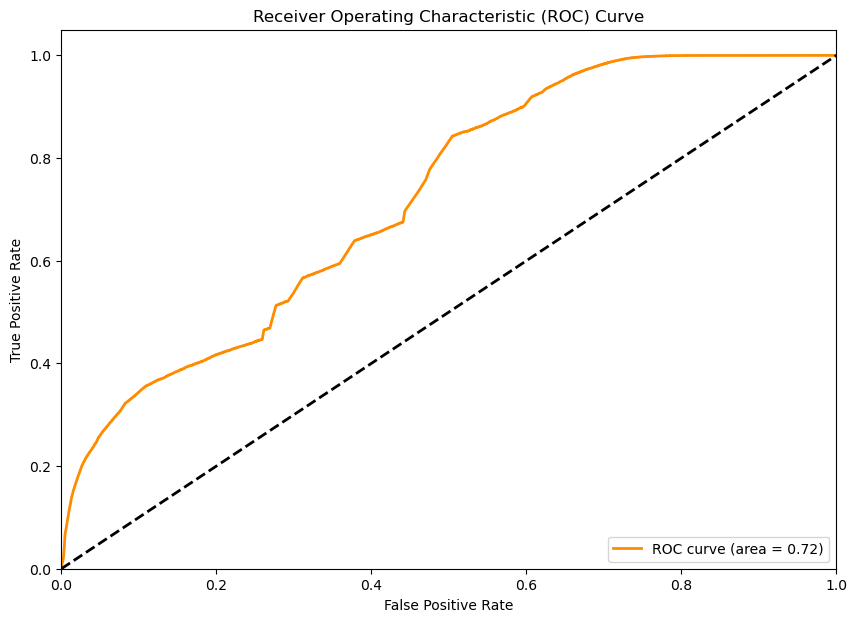

AUC: 0.7221
Accuracy: 0.7017
Precision: 0.9961
Recall: 0.7017
F1-score: 0.8225
Training Time: 22.1094 seconds
Testing Time: 1.0799 seconds

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.70      0.82   8425378
           1       0.00      0.53      0.01     20049

    accuracy                           0.70   8445427
   macro avg       0.50      0.62      0.42   8445427
weighted avg       1.00      0.70      0.82   8445427



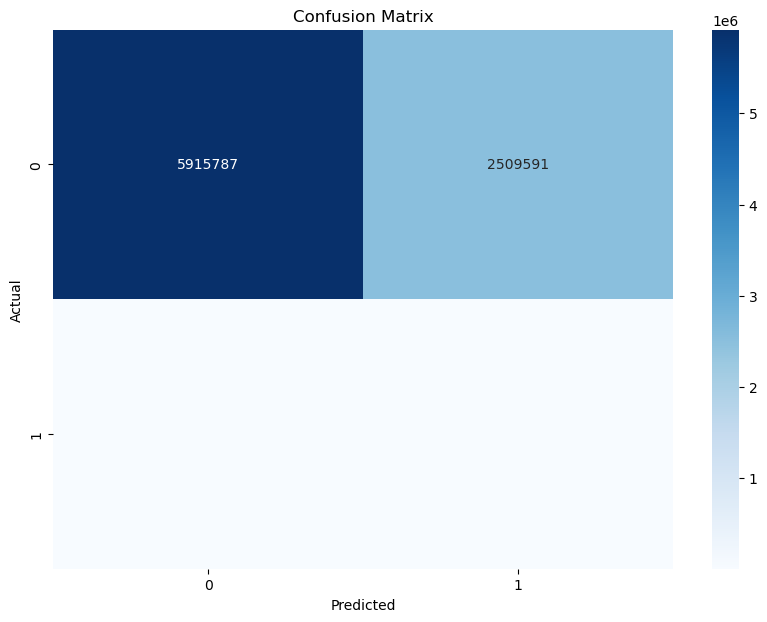

In [2]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_02_unknown_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Logistic Regression with class weight adjustment
clf = LogisticRegression(random_state=42, class_weight='balanced')

# Measure training time
start_train_time = time.time()
clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = clf.predict(X_test_scaled)
y_pred_prob = clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
classification_rep = classification_report(y_test, y_pred, zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Calculate ROC and AUC
n_classes = len(np.unique(y_train))

if n_classes == 2:
    # Binary classification case
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for binary classification
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class case
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))
print("\nClassification Report:\n", classification_rep)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Train and evaluate a LogisticRegression on a dataset that is stored in separate training and testing folders.(set02 test03 known vehicle, unknown attack)

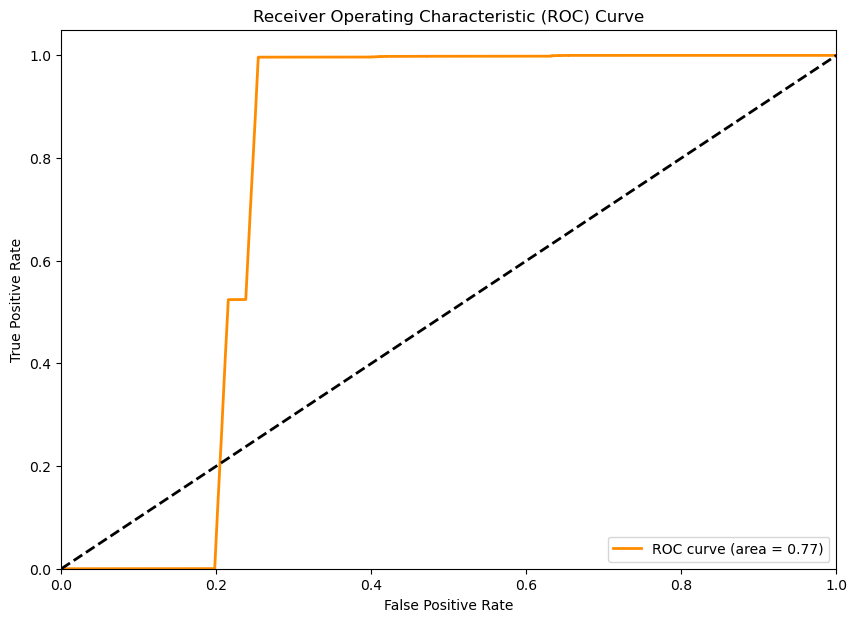

AUC: 0.7737
Accuracy: 0.8192
Precision: 0.9948
Recall: 0.8192
F1-score: 0.8985
Training Time: 22.4233 seconds
Testing Time: 1.1827 seconds

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.82      0.90  12121265
           1       0.00      0.00      0.00     28791

    accuracy                           0.82  12150056
   macro avg       0.50      0.41      0.45  12150056
weighted avg       0.99      0.82      0.90  12150056



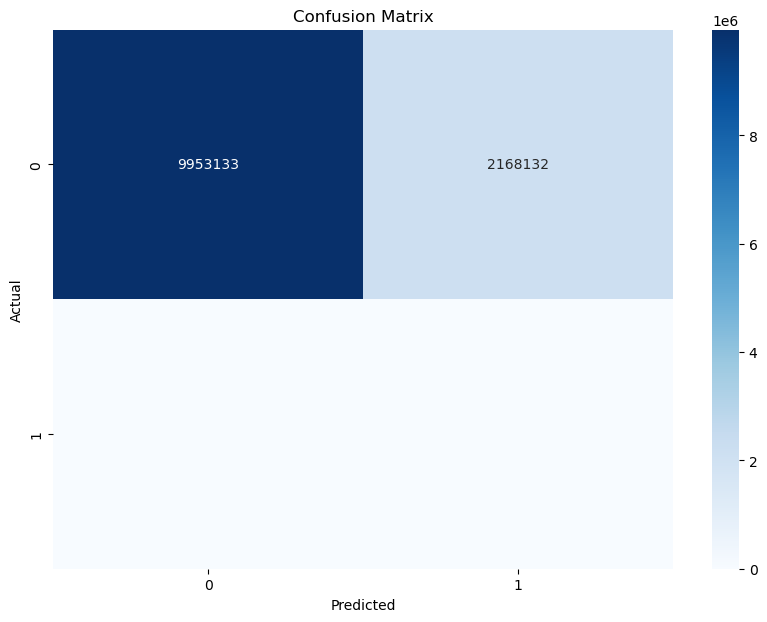

In [3]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_03_known_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Logistic Regression with class weight adjustment
clf = LogisticRegression(random_state=42, class_weight='balanced')

# Measure training time
start_train_time = time.time()
clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = clf.predict(X_test_scaled)
y_pred_prob = clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
classification_rep = classification_report(y_test, y_pred, zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Calculate ROC and AUC
n_classes = len(np.unique(y_train))

if n_classes == 2:
    # Binary classification case
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for binary classification
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class case
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))
print("\nClassification Report:\n", classification_rep)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Train and evaluate a LogisticRegression on a dataset that is stored in separate training and testing folders.(set02 test04 unknown vehicle, unknown attack)

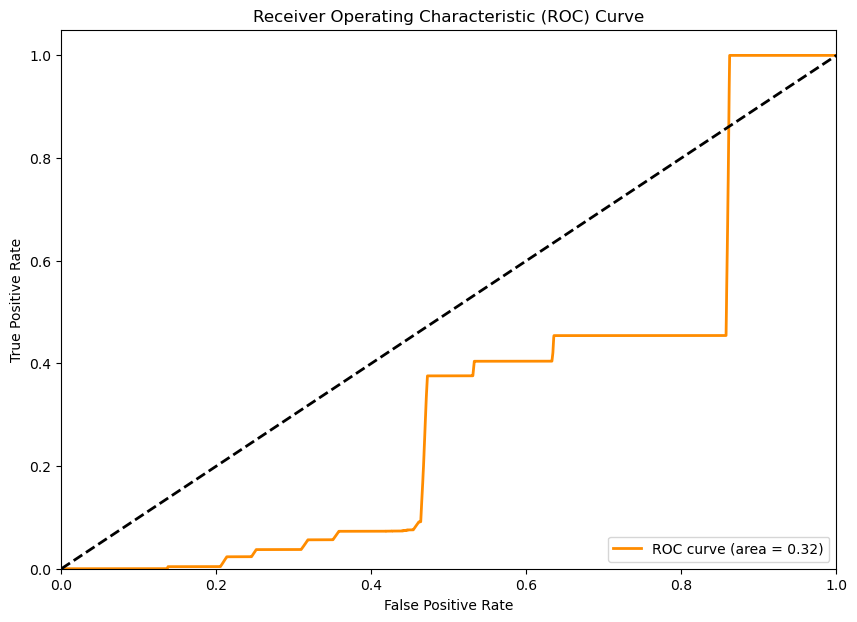

AUC: 0.3223
Accuracy: 0.7052
Precision: 0.9912
Recall: 0.7052
F1-score: 0.8240
Training Time: 21.7798 seconds
Testing Time: 0.5165 seconds

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.71      0.83   4771896
           1       0.00      0.04      0.00     18008

    accuracy                           0.71   4789904
   macro avg       0.50      0.37      0.41   4789904
weighted avg       0.99      0.71      0.82   4789904



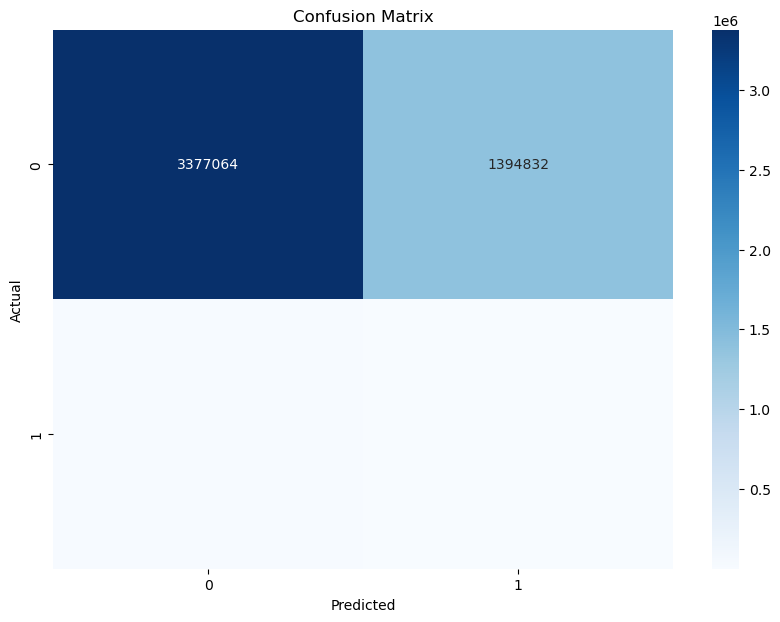

In [4]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_04_unknown_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Logistic Regression with class weight adjustment
clf = LogisticRegression(random_state=42, class_weight='balanced')

# Measure training time
start_train_time = time.time()
clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = clf.predict(X_test_scaled)
y_pred_prob = clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
classification_rep = classification_report(y_test, y_pred, zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Calculate ROC and AUC
n_classes = len(np.unique(y_train))

if n_classes == 2:
    # Binary classification case
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve for binary classification
    plt.figure(figsize=(10, 7))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label='ROC curve (area = {0:0.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class case
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))
print("\nClassification Report:\n", classification_rep)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## Train and evaluate a Birch on a dataset that is stored in separate training and testing folders.(set02 test 02 known vehicle, known attack)

Accuracy: 0.9990
Precision: 0.9988
Recall: 0.9990
F1-score: 0.9988
ROC AUC: 0.6301
Training Time: 628.5849 seconds
Testing Time: 279.6506 seconds


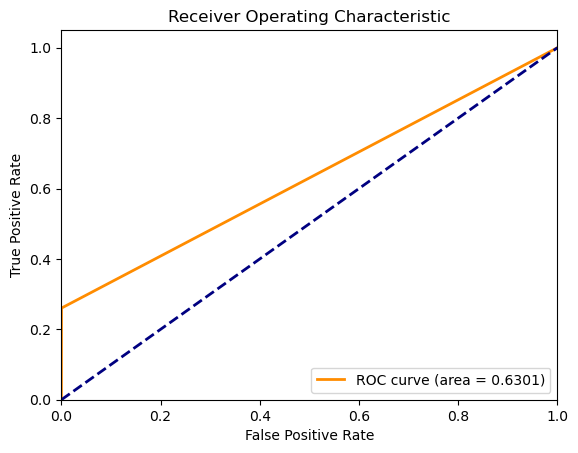

In [5]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = []
    for file in all_files:
        chunk = pd.read_csv(file, dtype={'arbitration_id': 'category', 'data_field': 'category'})
        df_list.append(chunk)
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_01_known_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply BIRCH clustering with adjusted threshold
birch = Birch(threshold=0.3, branching_factor=50, n_clusters=None)

# Measure training time
start_train_time = time.time()
birch.fit(X_train_scaled)
end_train_time = time.time()

# Predict cluster labels for training and testing data
start_test_time = time.time()
train_clusters = birch.predict(X_train_scaled)
test_clusters = birch.predict(X_test_scaled)
end_test_time = time.time()

# Find the majority label in each cluster for training data
majority_label = {}
for cluster in set(train_clusters):
    mask = train_clusters == cluster
    if mask.sum() > 0:
        majority_label[cluster] = y_train[mask].mode()[0]

# Convert cluster labels to predicted binary labels
pred_train_labels = [majority_label.get(cluster, 0) for cluster in train_clusters]
pred_test_labels = [majority_label.get(cluster, 0) for cluster in test_clusters]

# Evaluate the model
accuracy = accuracy_score(y_test, pred_test_labels)
precision = precision_score(y_test, pred_test_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, pred_test_labels, average='weighted', zero_division=0)
f1 = f1_score(y_test, pred_test_labels, average='weighted', zero_division=0)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, pred_test_labels)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("ROC AUC: {:.4f}".format(roc_auc))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Train and evaluate a Birch on a dataset that is stored in separate training and testing folders.(set02 test 02 unknown vehicle, known attack)

Accuracy: 0.9211
Precision: 0.9958
Recall: 0.9211
F1-score: 0.9567
ROC AUC: 0.6037
Training Time: 743.6631 seconds
Testing Time: 308.5721 seconds


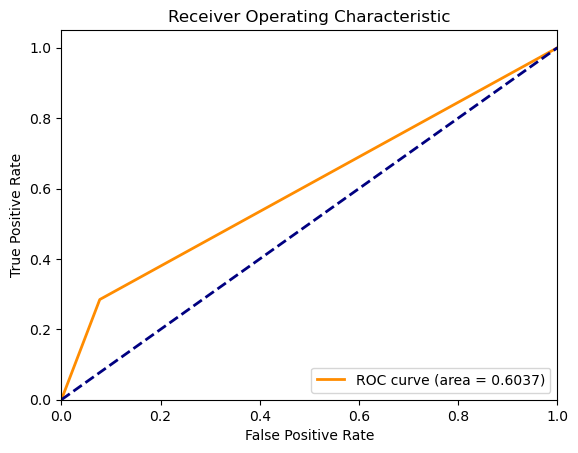

In [7]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = []
    for file in all_files:
        chunk = pd.read_csv(file, dtype={'arbitration_id': 'category', 'data_field': 'category'})
        df_list.append(chunk)
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_02_unknown_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply BIRCH clustering with adjusted threshold
birch = Birch(threshold=0.3, branching_factor=50, n_clusters=None)

# Measure training time
start_train_time = time.time()
birch.fit(X_train_scaled)
end_train_time = time.time()

# Predict cluster labels for training and testing data
start_test_time = time.time()
train_clusters = birch.predict(X_train_scaled)
test_clusters = birch.predict(X_test_scaled)
end_test_time = time.time()

# Find the majority label in each cluster for training data
majority_label = {}
for cluster in set(train_clusters):
    mask = train_clusters == cluster
    if mask.sum() > 0:
        majority_label[cluster] = y_train[mask].mode()[0]

# Convert cluster labels to predicted binary labels
pred_train_labels = [majority_label.get(cluster, 0) for cluster in train_clusters]
pred_test_labels = [majority_label.get(cluster, 0) for cluster in test_clusters]

# Evaluate the model
accuracy = accuracy_score(y_test, pred_test_labels)
precision = precision_score(y_test, pred_test_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, pred_test_labels, average='weighted', zero_division=0)
f1 = f1_score(y_test, pred_test_labels, average='weighted', zero_division=0)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, pred_test_labels)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("ROC AUC: {:.4f}".format(roc_auc))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Train and evaluate a Birch on a dataset that is stored in separate training and testing folders.(set02 test 03 known vehicle, unknown attack)

Accuracy: 0.9973
Precision: 0.9953
Recall: 0.9973
F1-score: 0.9963
ROC AUC: 0.4998
Training Time: 599.3017 seconds
Testing Time: 200.8912 seconds


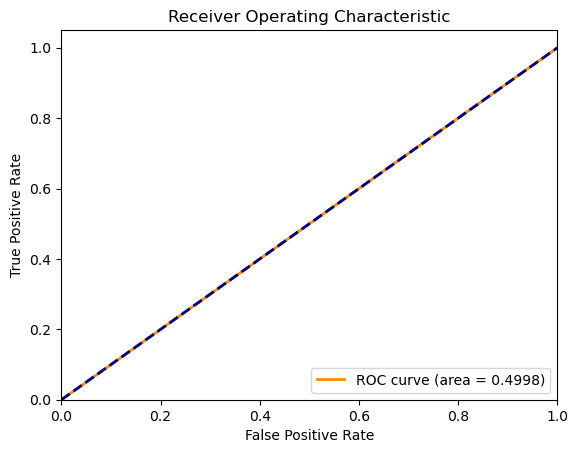

In [1]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = []
    for file in all_files:
        chunk = pd.read_csv(file, dtype={'arbitration_id': 'category', 'data_field': 'category'})
        df_list.append(chunk)
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_03_known_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply BIRCH clustering with adjusted threshold
birch = Birch(threshold=0.3, branching_factor=50, n_clusters=None)

# Measure training time
start_train_time = time.time()
birch.fit(X_train_scaled)
end_train_time = time.time()

# Predict cluster labels for training and testing data
start_test_time = time.time()
train_clusters = birch.predict(X_train_scaled)
test_clusters = birch.predict(X_test_scaled)
end_test_time = time.time()

# Find the majority label in each cluster for training data
majority_label = {}
for cluster in set(train_clusters):
    mask = train_clusters == cluster
    if mask.sum() > 0:
        majority_label[cluster] = y_train[mask].mode()[0]

# Convert cluster labels to predicted binary labels
pred_train_labels = [majority_label.get(cluster, 0) for cluster in train_clusters]
pred_test_labels = [majority_label.get(cluster, 0) for cluster in test_clusters]

# Evaluate the model
accuracy = accuracy_score(y_test, pred_test_labels)
precision = precision_score(y_test, pred_test_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, pred_test_labels, average='weighted', zero_division=0)
f1 = f1_score(y_test, pred_test_labels, average='weighted', zero_division=0)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, pred_test_labels)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("ROC AUC: {:.4f}".format(roc_auc))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Train and evaluate a Birch on a dataset that is stored in separate training and testing folders.(set02 test 04 unknown vehicle, unknown attack)

Accuracy: 0.8966
Precision: 0.9921
Recall: 0.8966
F1-score: 0.9419
ROC AUC: 0.4500
Training Time: 633.5316 seconds
Testing Time: 557.4189 seconds


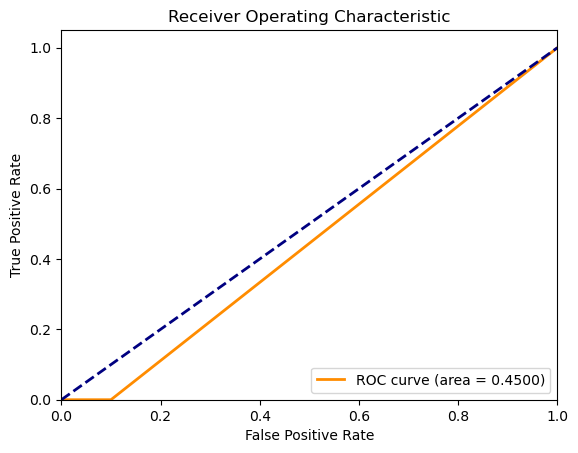

In [2]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import Birch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = []
    for file in all_files:
        chunk = pd.read_csv(file, dtype={'arbitration_id': 'category', 'data_field': 'category'})
        df_list.append(chunk)
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_04_unknown_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply BIRCH clustering with adjusted threshold
birch = Birch(threshold=0.3, branching_factor=50, n_clusters=None)

# Measure training time
start_train_time = time.time()
birch.fit(X_train_scaled)
end_train_time = time.time()

# Predict cluster labels for training and testing data
start_test_time = time.time()
train_clusters = birch.predict(X_train_scaled)
test_clusters = birch.predict(X_test_scaled)
end_test_time = time.time()

# Find the majority label in each cluster for training data
majority_label = {}
for cluster in set(train_clusters):
    mask = train_clusters == cluster
    if mask.sum() > 0:
        majority_label[cluster] = y_train[mask].mode()[0]

# Convert cluster labels to predicted binary labels
pred_train_labels = [majority_label.get(cluster, 0) for cluster in train_clusters]
pred_test_labels = [majority_label.get(cluster, 0) for cluster in test_clusters]

# Evaluate the model
accuracy = accuracy_score(y_test, pred_test_labels)
precision = precision_score(y_test, pred_test_labels, average='weighted', zero_division=0)
recall = recall_score(y_test, pred_test_labels, average='weighted', zero_division=0)
f1 = f1_score(y_test, pred_test_labels, average='weighted', zero_division=0)

# Calculate ROC AUC
roc_auc = roc_auc_score(y_test, pred_test_labels)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("ROC AUC: {:.4f}".format(roc_auc))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_test_labels)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## Train and evaluate a KNeighborsClassifier on a dataset that is stored in separate training and testing folders.(set02 test 01 known vehicle, known attack)

Accuracy: 0.9984
Precision: 0.9987
Recall: 0.9984
F1-score: 0.9985
Training Time: 67.9171 seconds
Testing Time: 1059.3668 seconds


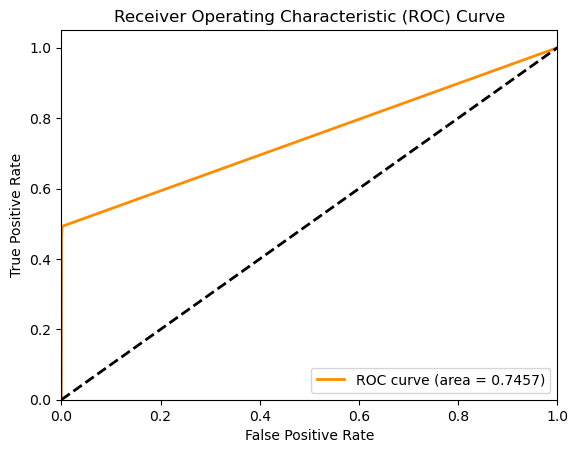

AUC: 0.7457


In [4]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_01_known_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply K-Nearest Neighbors (KNN) with a chosen number of neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Measure training time
start_train_time = time.time()
knn.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = knn.predict(X_test_scaled)
y_pred_prob = knn.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a KNeighborsClassifier on a dataset that is stored in separate training and testing folders.(set02 test 02 unknown vehicle, known attack)

Accuracy: 0.5081
Precision: 0.9968
Recall: 0.5081
F1-score: 0.6714
Training Time: 73.3017 seconds
Testing Time: 764.3329 seconds


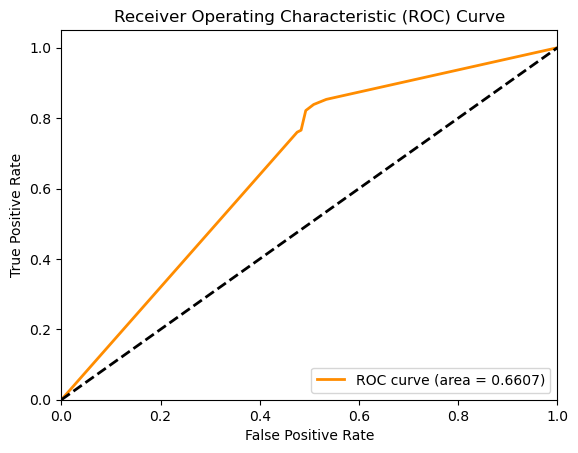

AUC: 0.6607


In [5]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_02_unknown_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply K-Nearest Neighbors (KNN) with a chosen number of neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Measure training time
start_train_time = time.time()
knn.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = knn.predict(X_test_scaled)
y_pred_prob = knn.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))



## Train and evaluate a KNeighborsClassifier on a dataset that is stored in separate training and testing folders.(set01 test 03 known vehicle, unknown attack)

Accuracy: 0.9969
Precision: 0.9953
Recall: 0.9969
F1-score: 0.9961
Training Time: 71.1247 seconds
Testing Time: 977.8771 seconds


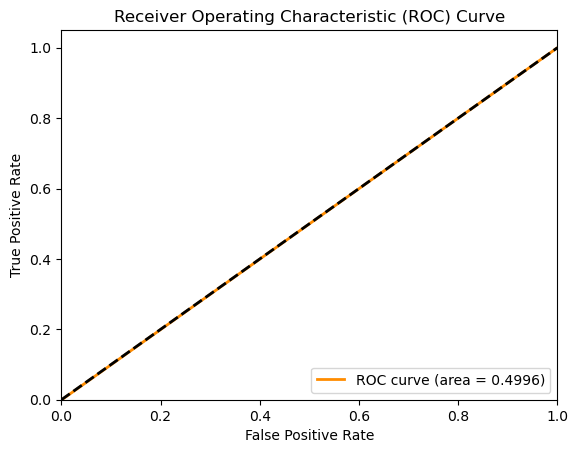

AUC: 0.4996


In [6]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_03_known_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply K-Nearest Neighbors (KNN) with a chosen number of neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Measure training time
start_train_time = time.time()
knn.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = knn.predict(X_test_scaled)
y_pred_prob = knn.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a KNeighborsClassifier on a dataset that is stored in separate training and testing folders.(set02 test 04 unknown vehicle, unknown attack)

Accuracy: 0.5351
Precision: 0.9957
Recall: 0.5351
F1-score: 0.6932
Training Time: 75.5551 seconds
Testing Time: 438.8870 seconds


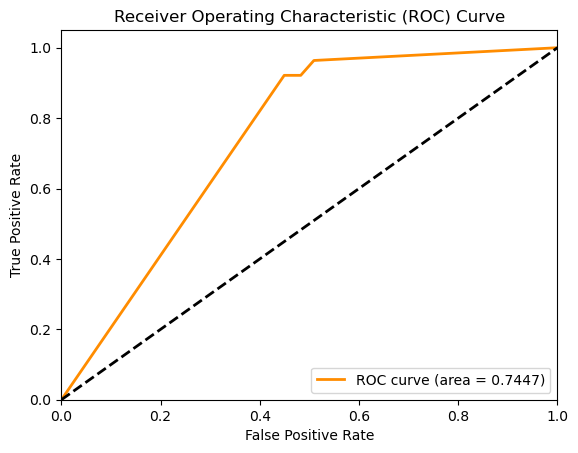

AUC: 0.7447


In [7]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_04_unknown_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply K-Nearest Neighbors (KNN) with a chosen number of neighbors
knn = KNeighborsClassifier(n_neighbors=5)

# Measure training time
start_train_time = time.time()
knn.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = knn.predict(X_test_scaled)
y_pred_prob = knn.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a MLPClassifier on a dataset that is stored in separate training and testing folders.(set02 test01 known vehicle, known attack)

Accuracy: 0.9987
Precision: 0.9986
Recall: 0.9987
F1-score: 0.9986
Training Time: 1735.6975 seconds
Testing Time: 114.8802 seconds


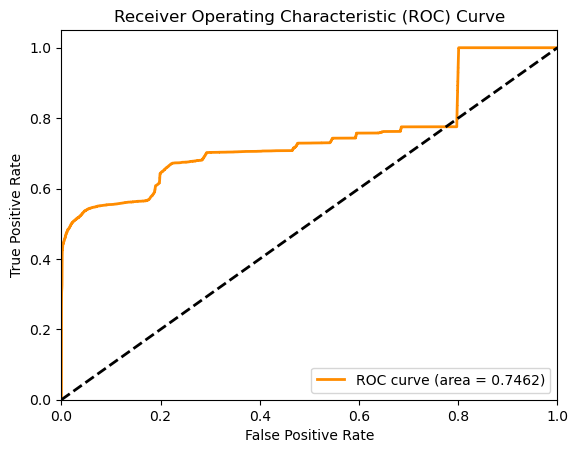

AUC: 0.7462


In [8]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_01_known_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Downsample the data (optional)
train_data = train_data.sample(frac=0.5, random_state=42)  # Adjust fraction as needed
test_data = test_data.sample(frac=0.5, random_state=42)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features and convert to float32
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# Apply Multi-Layer Perceptron (MLP) with a chosen configuration
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)

# Measure training time
start_train_time = time.time()
mlp.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = mlp.predict(X_test_scaled)
y_pred_prob = mlp.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


Accuracy: 0.6788
Precision: 0.9953
Recall: 0.6788
F1-score: 0.8066
Training Time: 1983.2540 seconds
Testing Time: 11.8107 seconds


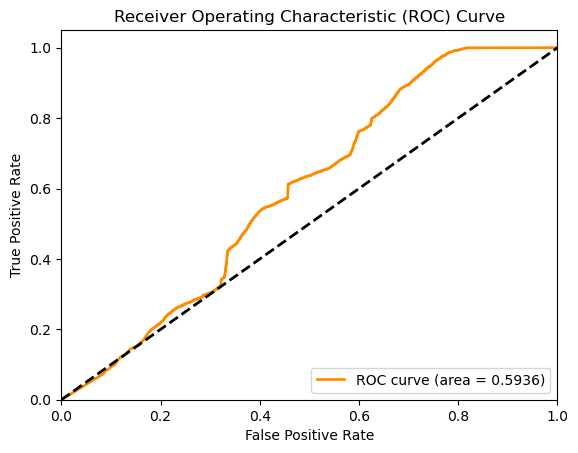

AUC: 0.5936


In [9]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_02_unknown_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Downsample the data (optional)
train_data = train_data.sample(frac=0.5, random_state=42)  # Adjust fraction as needed
test_data = test_data.sample(frac=0.5, random_state=42)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features and convert to float32
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# Apply Multi-Layer Perceptron (MLP) with a chosen configuration
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)

# Measure training time
start_train_time = time.time()
mlp.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = mlp.predict(X_test_scaled)
y_pred_prob = mlp.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


Accuracy: 0.9973
Precision: 0.9953
Recall: 0.9973
F1-score: 0.9963
Training Time: 2151.6526 seconds
Testing Time: 95.1973 seconds


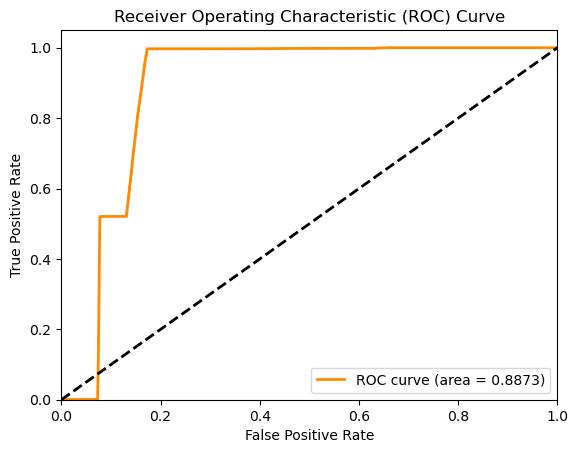

AUC: 0.8873


In [10]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_03_known_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Downsample the data (optional)
train_data = train_data.sample(frac=0.5, random_state=42)  # Adjust fraction as needed
test_data = test_data.sample(frac=0.5, random_state=42)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features and convert to float32
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# Apply Multi-Layer Perceptron (MLP) with a chosen configuration
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)

# Measure training time
start_train_time = time.time()
mlp.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = mlp.predict(X_test_scaled)
y_pred_prob = mlp.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


Accuracy: 0.7888
Precision: 0.9954
Recall: 0.7888
F1-score: 0.8783
Training Time: 1875.6479 seconds
Testing Time: 4.8807 seconds


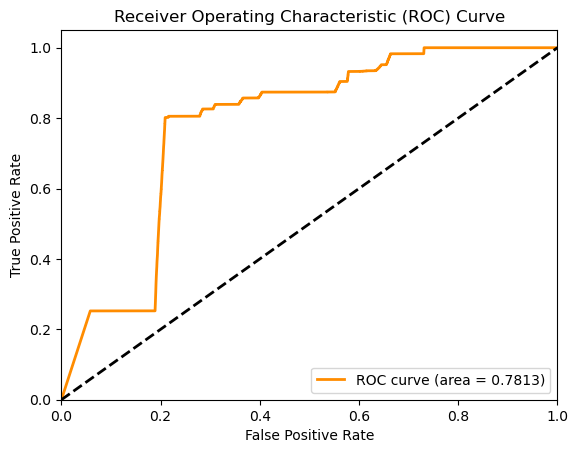

AUC: 0.7813


In [11]:
import os
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_04_unknown_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Downsample the data (optional)
train_data = train_data.sample(frac=0.5, random_state=42)  # Adjust fraction as needed
test_data = test_data.sample(frac=0.5, random_state=42)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features and convert to float32
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

# Apply Multi-Layer Perceptron (MLP) with a chosen configuration
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', random_state=42)

# Measure training time
start_train_time = time.time()
mlp.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = mlp.predict(X_test_scaled)
y_pred_prob = mlp.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print the results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a DecisionTreeClassifier on a dataset that is stored in separate training and testing folders.(set02 test 01 known vehicle, known attack)


Decision Tree Results
Accuracy: 0.9989
Precision: 0.9989
Recall: 0.9989
F1-score: 0.9989
Training Time: 165.6186 seconds
Testing Time: 5.7423 seconds


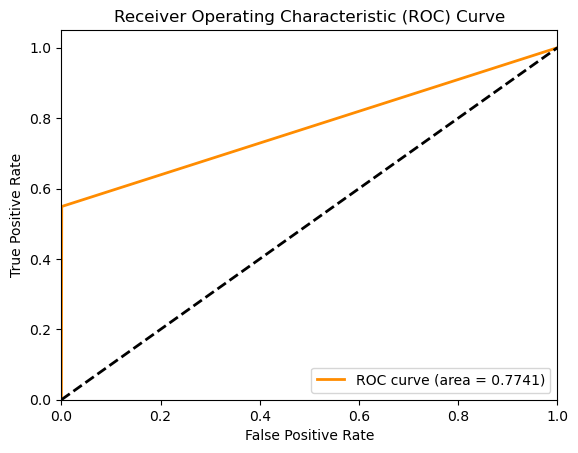

AUC: 0.7741


In [1]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_01_known_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Measure training time for Decision Tree
start_train_time = time.time()
dt_clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = dt_clf.predict(X_test_scaled)
y_pred_prob = dt_clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the Decision Tree model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print Decision Tree results
print("\nDecision Tree Results")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a DecisionTreeClassifier on a dataset that is stored in separate training and testing folders.(set02 test 02 unknown vehicle, known attack)


Decision Tree Results
Accuracy: 0.4656
Precision: 0.9964
Recall: 0.4656
F1-score: 0.6330
Training Time: 162.2179 seconds
Testing Time: 3.6407 seconds


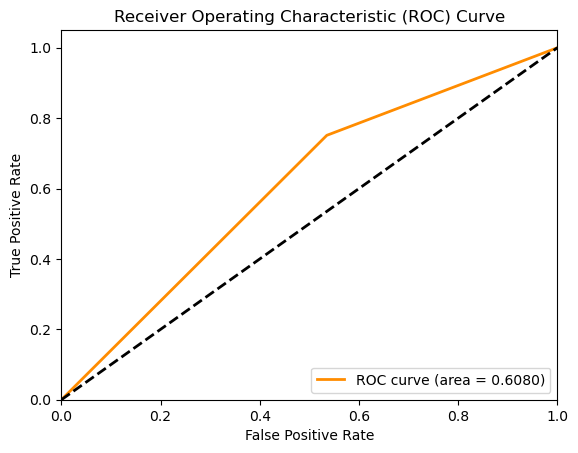

AUC: 0.6080


In [2]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_02_unknown_vehicle_known_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Measure training time for Decision Tree
start_train_time = time.time()
dt_clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = dt_clf.predict(X_test_scaled)
y_pred_prob = dt_clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the Decision Tree model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print Decision Tree results
print("\nDecision Tree Results")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a DecisionTreeClassifier on a dataset that is stored in separate training and testing folders.(set02 test 03 known vehicle, unknown attack)


Decision Tree Results
Accuracy: 0.9967
Precision: 0.9953
Recall: 0.9967
F1-score: 0.9960
Training Time: 182.5905 seconds
Testing Time: 6.5570 seconds


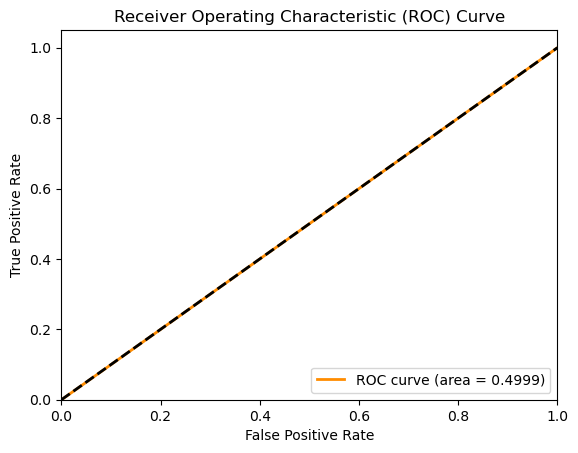

AUC: 0.4999


In [3]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_03_known_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Measure training time for Decision Tree
start_train_time = time.time()
dt_clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = dt_clf.predict(X_test_scaled)
y_pred_prob = dt_clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the Decision Tree model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print Decision Tree results
print("\nDecision Tree Results")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))


## Train and evaluate a DecisionTreeClassifier on a dataset that is stored in separate training and testing folders.(set02 test 04 unknown vehicle, unknown attack)


Decision Tree Results
Accuracy: 0.4664
Precision: 0.9952
Recall: 0.4664
F1-score: 0.6321
Training Time: 163.6634 seconds
Testing Time: 2.1684 seconds


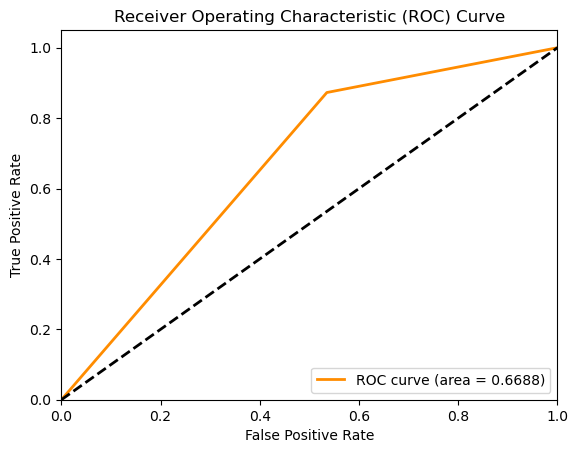

AUC: 0.6688


In [4]:
import os
import time
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.preprocessing import label_binarize

# Function to load all CSV files from a folder into a single DataFrame
def load_data_from_folder(folder_path):
    all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

# Load training and testing data
train_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\train_01"
test_folder = r"C:\Users\Lerin\Project Master's\New\can-train-and-test\set_02\test_04_unknown_vehicle_unknown_attack"

train_data = load_data_from_folder(train_folder)
test_data = load_data_from_folder(test_folder)

# Add a column to distinguish between training and testing data
train_data['is_train'] = True
test_data['is_train'] = False

# Combine the datasets
combined_data = pd.concat([train_data, test_data], ignore_index=True)

# Initialize label encoders
label_enc_arbitration_id = LabelEncoder()
label_enc_data_field = LabelEncoder()

# Apply label encoding to the combined data
combined_data['arbitration_id'] = label_enc_arbitration_id.fit_transform(combined_data['arbitration_id'])
combined_data['data_field'] = label_enc_data_field.fit_transform(combined_data['data_field'])

# Split the data back into training and testing sets
train_data = combined_data[combined_data['is_train']].drop('is_train', axis=1)
test_data = combined_data[~combined_data['is_train']].drop('is_train', axis=1)

# Separate features and target
X_train = train_data.drop('attack', axis=1)
y_train = train_data['attack']
X_test = test_data.drop('attack', axis=1)
y_test = test_data['attack']

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Measure training time for Decision Tree
start_train_time = time.time()
dt_clf.fit(X_train_scaled, y_train)
end_train_time = time.time()

# Make predictions on the test set
start_test_time = time.time()
y_pred = dt_clf.predict(X_test_scaled)
y_pred_prob = dt_clf.predict_proba(X_test_scaled)
end_test_time = time.time()

# Evaluate the Decision Tree model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

# Calculate training and testing time
train_time = end_train_time - start_train_time
test_time = end_test_time - start_test_time

# Print Decision Tree results
print("\nDecision Tree Results")
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-score: {:.4f}".format(f1))
print("Training Time: {:.4f} seconds".format(train_time))
print("Testing Time: {:.4f} seconds".format(test_time))

# ROC and AUC calculations
n_classes = len(y_train.unique())

if n_classes == 2:
    # Binary classification
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {0:0.4f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC: {:.4f}".format(roc_auc))
else:
    # Multi-class classification
    y_test_bin = label_binarize(y_test, classes=range(n_classes))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(10, 7))
    for i, color in zip(range(n_classes), cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green'])):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    # Print AUC for each class
    for i in range(n_classes):
        print("AUC of class {0}: {1:0.4f}".format(i, roc_auc[i]))
